In [33]:
%cd /Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model

from utils.post_training import *
from utils.statistics import *
from utils.plotting import *
from utils.angle_encoding_script import angle_encoding
from utils.haar_noising_script import apply_haar_scrambling

import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import os
import math

import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim_func

import pennylane as qml

/Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model


In [34]:
device = "mps" if torch.mps.is_available() else "cpu"
print(f"Using device: {device}")

filename = "data/QG1_64x64_1k"
data_X = np.array(h5py.File(filename, "r")['X'])
data_X = np.log1p(data_X.astype(np.float32))
data_X = data_X / data_X.max()
data_X = 2.0 * data_X - 1.0 # Range [-1, 1]

Using device: mps


In [61]:
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev, interface="torch")
def sensitive_circuit(inputs):
    # inputs range [-1, 1]
    
    # Mapping [-1, 1] -> [pi/2, pi]
    # x=-1 -> pi/2
    # x= 1 -> pi
    # Formula: theta = pi/2 + (x + 1) * (pi/4)
    # Range check: -1 -> pi/2 + 0 = pi/2. 
    #               1 -> pi/2 + 2*pi/4 = pi. 
    thetas = (np.pi / 2.0) + (inputs + 1.0) * (np.pi / 4.0)
    
    qml.RY(thetas, wires=0)
    return qml.expval(qml.PauliZ(0))

def embed_sensitive(images):
    N, H, W = images.shape
    flat_pixels = torch.tensor(images).view(-1)
    
    batch_size = 16384
    results = []
    
    with torch.no_grad():
        for i in range(0, len(flat_pixels), batch_size):
            batch = flat_pixels[i : i + batch_size]
            results.append(sensitive_circuit(batch))
            
    results = torch.cat(results, dim=0)
    return results.reshape(N, 1, H, W).float()

quantum_data_sensitive = embed_sensitive(data_X)

Deepest Signal Value found: -1.000000


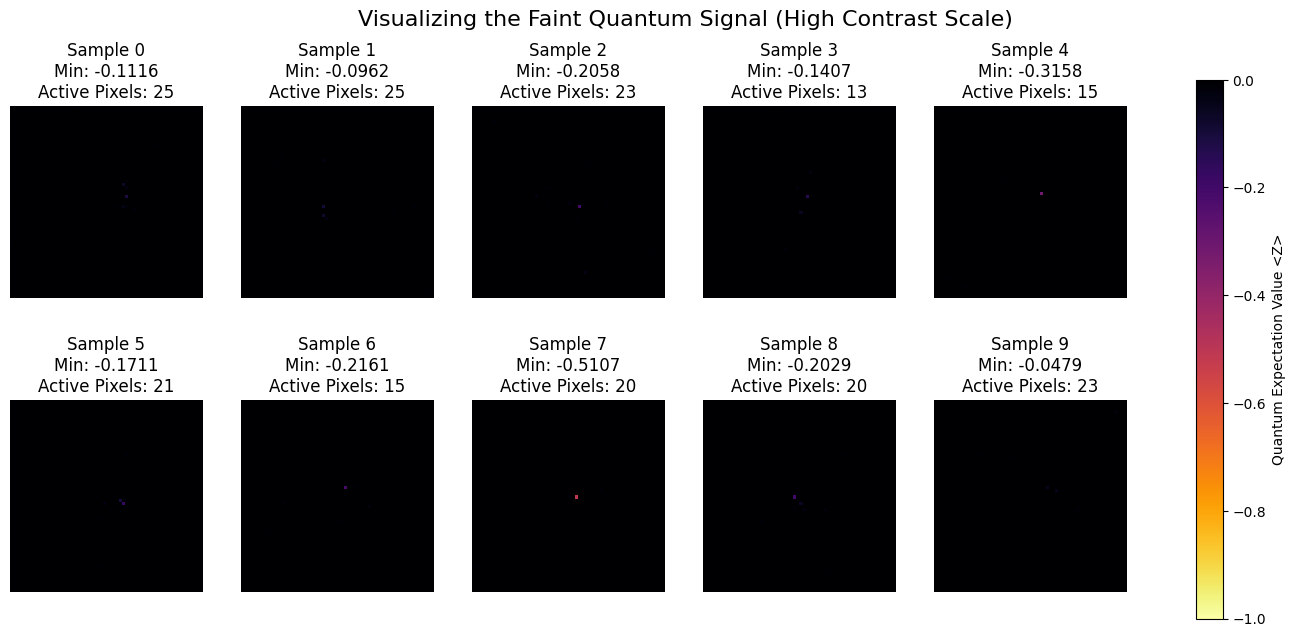

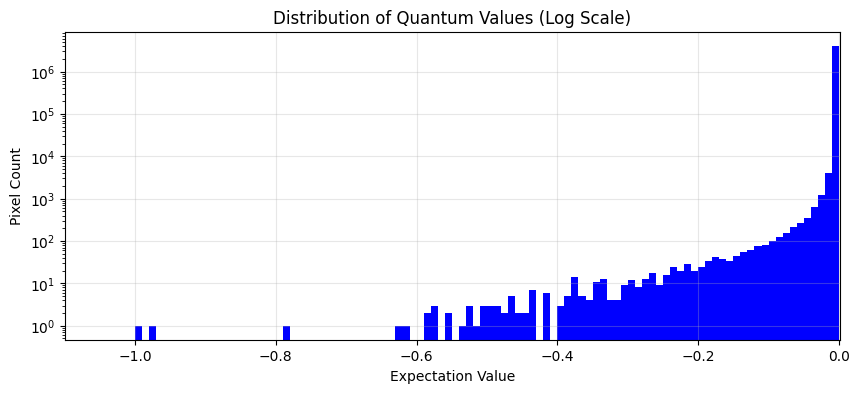

In [ ]:
def plot_faint_quantum_data(tensor_data):
    imgs = tensor_data.cpu().numpy()
    
    # Find the strongest signal (most negative value) to set the scale
    global_min = imgs.min()
    print(f"Deepest Signal Value found: {global_min:.6f}")
    
    fig, axs = plt.subplots(2, 5, figsize=(18, 7))
    
    for i in range(10): 
        row = i // 5
        col = i % 5
        
        img = imgs[i].squeeze()

        im = axs[row, col].imshow(img, cmap='inferno_r', vmin=global_min, vmax=0.0)
        
        # We count anything with deviation > 0.0001
        active_pixels = (img < -0.0001).sum()
        
        axs[row, col].set_title(f"Sample {i}\nMin: {img.min():.4f}\nActive Pixels: {active_pixels}")
        axs[row, col].axis('off')

    cbar = fig.colorbar(im, ax=axs.ravel().tolist())
    cbar.set_label("Quantum Expectation Value <Z>")
    plt.suptitle("Visualizing the Faint Quantum Signal (High Contrast Scale)", fontsize=16)
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.hist(imgs.flatten(), bins=100, log=True, color='blue')
    plt.title("Distribution of Quantum Values (Log Scale)")
    plt.xlabel("Expectation Value")
    plt.ylabel("Pixel Count")
    # Zoom in on the negative side
    plt.xlim(global_min * 1.1, 0.001) 
    plt.grid(True, alpha=0.3)
    plt.show()

plot_faint_quantum_data(quantum_data_sensitive)

Embedding with Amplification (Gain=30.0)...
Amplified Data Stats:
  Background (Target 0.0): 0.0000
  Deepest Signal (Target -1.0): -1.0000
  Mean Signal: -0.0027


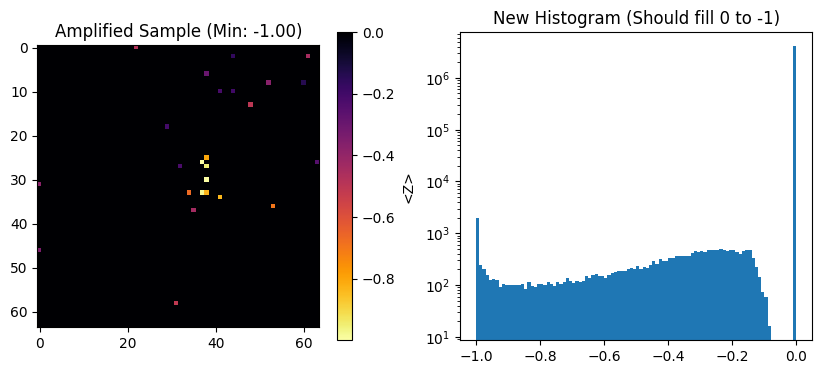

In [ ]:
# Gain Factor: How much to boost the faint signal
# Signal (x+1) is usually ~0.01. 
# Gain 30 => 0.01 * 30 = 0.3. 
# Angle shift = 0.3 * pi/2 => Significant rotation.
GAIN = 30.0 

dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev, interface="torch")
def amplified_circuit(inputs):
    # inputs: range [-1, 1], but most data is in [-1, -0.9]
    
    val = inputs + 1.0
    
    val = val * GAIN
    
    # If a pixel is unexpectedly bright, tanh caps it so we don't rotate past 180 deg
    val = torch.tanh(val) 
    
    # 0 -> pi/2 (Background) -> cos=0
    # 1 -> pi   (Max Signal) -> cos=-1
    thetas = (np.pi / 2.0) + val * (np.pi / 2.0)
    
    qml.RY(thetas, wires=0)
    return qml.expval(qml.PauliZ(0))

def embed_amplified(images):
    print(f"Embedding with Amplification (Gain={GAIN})...")
    N, H, W = images.shape
    flat_pixels = torch.tensor(images).view(-1)
    
    batch_size = 16384
    results = []
    
    with torch.no_grad():
        for i in range(0, len(flat_pixels), batch_size):
            batch = flat_pixels[i : i + batch_size]
            results.append(amplified_circuit(batch))
            
    results = torch.cat(results, dim=0)
    return results.reshape(N, 1, H, W).float()

quantum_data_amp = embed_amplified(data_X)

print("Amplified Data Stats:")
print(f"  Background (Target 0.0): {quantum_data_amp.max():.4f}")
print(f"  Deepest Signal (Target -1.0): {quantum_data_amp.min():.4f}")
print(f"  Mean Signal: {quantum_data_amp.mean():.4f}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(quantum_data_amp[0].squeeze(), cmap='inferno_r')
plt.colorbar(label="<Z>")
plt.title(f"Amplified Sample (Min: {quantum_data_amp[0].min():.2f})")

plt.subplot(1, 2, 2)
plt.hist(quantum_data_amp.flatten().numpy(), bins=100, log=True)
plt.title("New Histogram (Should fill 0 to -1)")
plt.show()

In [63]:
class PixelDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Learnable inverse function
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 1),
            nn.ReLU(),
            nn.Conv2d(16, 1, 1) # Output 1 channel
        )
        
    def forward(self, x):
        return self.net(x)

decoder = PixelDecoder().to(device)
opt_dec = optim.Adam(decoder.parameters(), lr=1e-3)
crit_dec = nn.MSELoss()

dset_dec = TensorDataset(quantum_data.to(device), torch.tensor(data_X).unsqueeze(1).to(device))
loader_dec = DataLoader(dset_dec, batch_size=64, shuffle=True)

for epoch in range(10):
    total_loss = 0
    for q, real in loader_dec:
        pred = decoder(q)
        loss = crit_dec(pred, real)
        opt_dec.zero_grad()
        loss.backward()
        opt_dec.step()
        total_loss += loss.item()
    if epoch % 2 == 0:
        print(f"Epoch {epoch}: {total_loss/len(loader_dec):.6f}")

decoder.eval()

Epoch 0: 1.489338
Epoch 2: 0.722107
Epoch 4: 0.258074
Epoch 6: 0.032537
Epoch 8: 0.000164


PixelDecoder(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [64]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.lin = nn.Sequential(nn.Linear(dim, dim), nn.SiLU(), nn.Linear(dim, dim))
    def forward(self, t):
        half = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(0, half, device=t.device) / half)
        args = t.unsqueeze(-1) * freqs.unsqueeze(0)
        return self.lin(torch.cat([torch.sin(args), torch.cos(args)], dim=-1))

class CoordUNet(nn.Module):
    def __init__(self, in_ch=4):
        super().__init__()
        self.time_emb = TimeEmbedding(64)
        
        # In: 4 quantum + 2 coord = 6
        self.inc = nn.Conv2d(in_ch + 2, 64, 3, padding=1)
        self.down1 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.SiLU())
        self.down2 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.SiLU())
        self.mid = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.SiLU())
        
        self.t_mlp1 = nn.Linear(64, 128)
        self.t_mlp2 = nn.Linear(64, 256)
        
        self.up1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.SiLU())
        self.up2 = nn.Sequential(nn.ConvTranspose2d(256, 64, 4, 2, 1), nn.SiLU())
        self.outc = nn.Conv2d(64, in_ch, 3, padding=1)

    def forward(self, x, t):
        B, C, H, W = x.shape
        # Add Coordinates
        yy, xx = torch.meshgrid(torch.linspace(-1,1,H,device=x.device), torch.linspace(-1,1,W,device=x.device), indexing='ij')
        x_in = torch.cat([x, yy.expand(B,1,H,W), xx.expand(B,1,H,W)], dim=1)
        
        t_emb = self.time_emb(t)
        x1 = F.silu(self.inc(x_in))
        x2 = self.down1(x1) + self.t_mlp1(t_emb)[...,None,None]
        x3 = self.down2(x2) + self.t_mlp2(t_emb)[...,None,None]
        mid = self.mid(x3)
        u1 = self.up1(mid)
        u1 = torch.cat([u1, x2], dim=1)
        u2 = self.up2(u1)
        return self.outc(u2 + x1)

In [ ]:
class CoordUNet(nn.Module):
    def __init__(self, in_ch=1): # Changed to 1 channel
        super().__init__()
        self.time_emb = TimeEmbedding(64)
        
        # In: 1 quantum + 2 coord = 3
        self.inc = nn.Conv2d(in_ch + 2, 64, 3, padding=1)
        self.down1 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.SiLU())
        self.down2 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.SiLU())
        self.mid = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.SiLU())
        
        self.t_mlp1 = nn.Linear(64, 128)
        self.t_mlp2 = nn.Linear(64, 256)
        
        self.up1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.SiLU())
        self.up2 = nn.Sequential(nn.ConvTranspose2d(256, 64, 4, 2, 1), nn.SiLU())
        self.outc = nn.Conv2d(64, in_ch, 3, padding=1)

    def forward(self, x, t):
        B, C, H, W = x.shape
        yy, xx = torch.meshgrid(torch.linspace(-1,1,H,device=x.device), torch.linspace(-1,1,W,device=x.device), indexing='ij')
        x_in = torch.cat([x, yy.expand(B,1,H,W), xx.expand(B,1,H,W)], dim=1)
        
        t_emb = self.time_emb(t)
        x1 = F.silu(self.inc(x_in))
        x2 = self.down1(x1) + self.t_mlp1(t_emb)[...,None,None]
        x3 = self.down2(x2) + self.t_mlp2(t_emb)[...,None,None]
        mid = self.mid(x3)
        u1 = self.up1(mid)
        u1 = torch.cat([u1, x2], dim=1)
        u2 = self.up2(u1)
        return self.outc(u2 + x1)

Epoch 10: Loss 0.27198
Epoch 20: Loss 0.23525
Epoch 30: Loss 0.23293
Epoch 40: Loss 0.16870
Epoch 50: Loss 0.15286
Epoch 60: Loss 0.07777
Epoch 70: Loss 0.05763
Epoch 80: Loss 0.05029
Epoch 90: Loss 0.03853
Epoch 100: Loss 0.02339


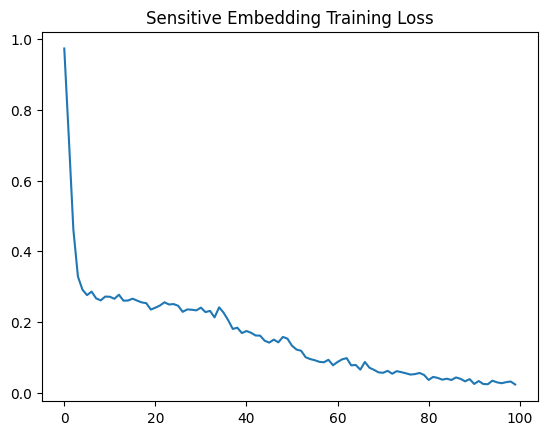

In [66]:
def zero_centered_loss(pred, target, x1_data, weight_factor=20.0):
    """
    x1_data:
       Background ~ 0.0
       Signal ~ -0.7 to -1.0
    """
    # Simply use magnitude of signal as importance
    # 0.0 -> Weight 1.0
    # -1.0 -> Weight 21.0
    weights = 1.0 + (weight_factor * torch.abs(x1_data))
    
    diff = (pred - target) ** 2
    return (diff * weights).mean()

model = CoordUNet(in_ch=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loader = DataLoader(TensorDataset(quantum_data_sensitive.to(device)), batch_size=32, shuffle=True)

losses = []

for epoch in range(1, 101):
    model.train()
    batch_loss = 0.0
    for (x1,) in loader:
        # Standard Flow Pipeline
        x0 = torch.randn_like(x1)
        t = torch.rand(x1.size(0), device=device)
        t_view = t.view(-1, 1, 1, 1)
        x_t = (1-t_view)*x0 + t_view*x1
        target_v = x1 - x0
        
        pred_v = model(x_t, t)
        
        # Loss
        loss = zero_centered_loss(pred_v, target_v, x1)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        batch_loss += loss.item()
        
    avg = batch_loss / len(loader)
    losses.append(avg)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {avg:.5f}")

plt.plot(losses)
plt.title("Sensitive Embedding Training Loss")
plt.show()

In [70]:
decoder = PixelDecoder().to(device)
opt_dec = optim.Adam(decoder.parameters(), lr=1e-3)
crit_dec = nn.MSELoss()

dset_dec = TensorDataset(quantum_data_sensitive.to(device), torch.tensor(data_X).unsqueeze(1).to(device))
loader_dec = DataLoader(dset_dec, batch_size=64, shuffle=True)

print("Retraining Decoder...")
for epoch in range(20):
    total_loss = 0
    for q, real in loader_dec:
        pred = decoder(q)
        loss = crit_dec(pred, real)
        opt_dec.zero_grad()
        loss.backward()
        opt_dec.step()
        total_loss += loss.item()
decoder.eval()

Retraining Decoder...


PixelDecoder(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

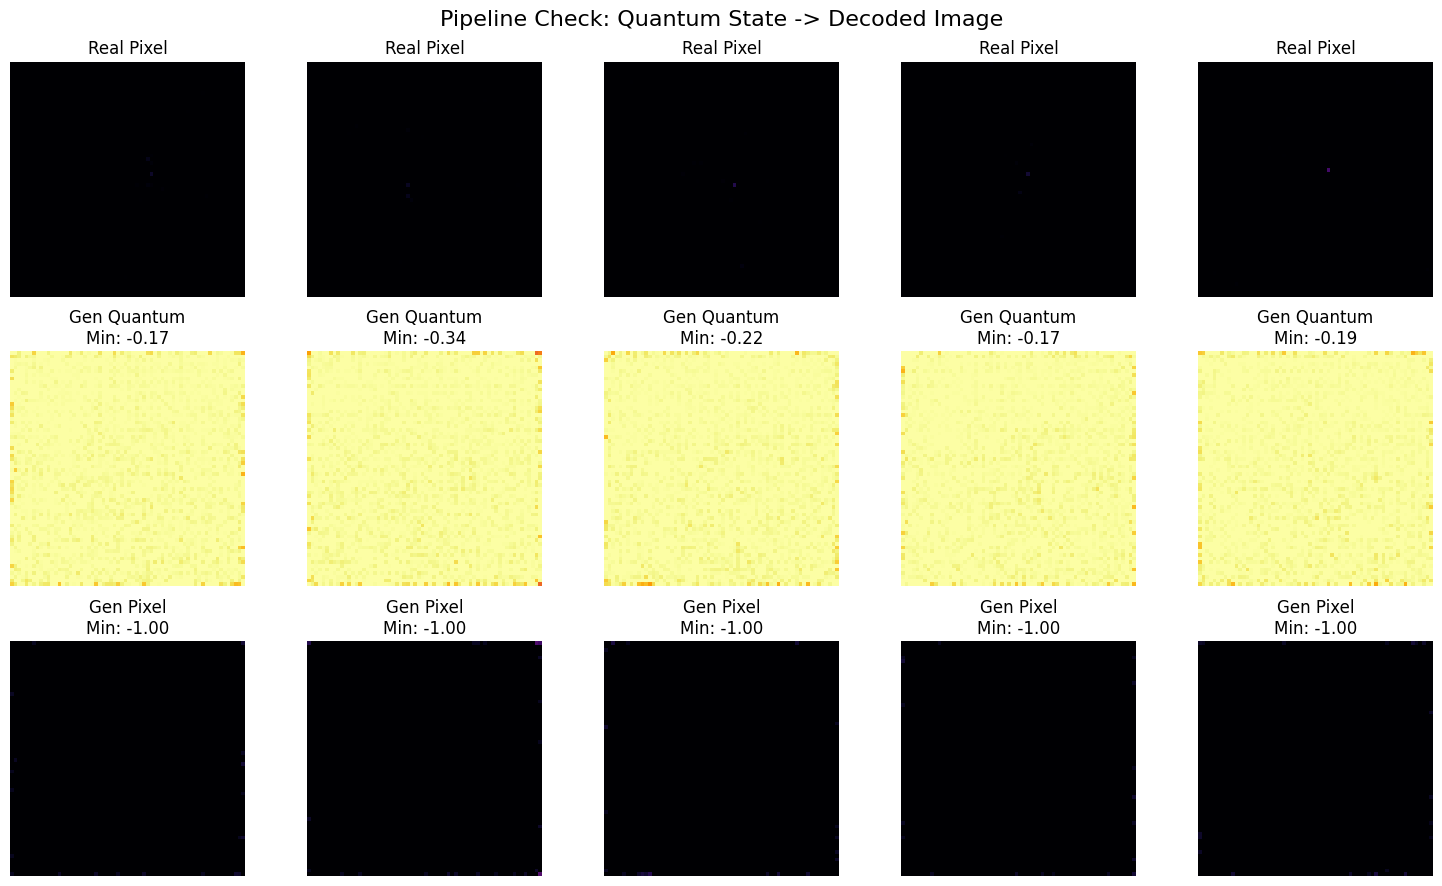

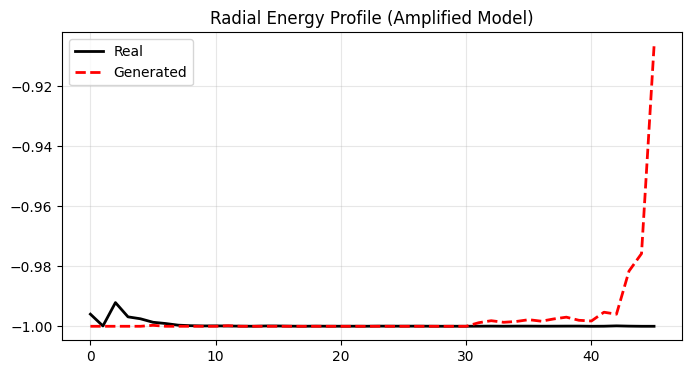

In [71]:

# %%
# [STEP 3: NEW EVALUATION]

@torch.no_grad()
def evaluate_amplified(model, decoder, n_samples=10):
    model.eval()
    decoder.eval()
    
    # 1. Sample Latent (Quantum Space)
    x = torch.randn(n_samples, 1, 64, 64, device=device)
    steps = 50
    dt = 1.0/steps
    
    for i in range(steps):
        t = torch.full((n_samples,), i/steps, device=device)
        v = model(x, t)
        x = x + v * dt
        
    quantum_samples = x # Keep these for visualization
    
    # 2. Decode
    images_raw = decoder(x)
    
    # 3. Clean
    # Physics Threshold: Background is -1.0.
    # Signal is > -0.99.
    images_clean = torch.where(images_raw < -0.9, torch.tensor(-1.0, device=device), images_raw)
    
    return quantum_samples.cpu().numpy(), images_clean.cpu().numpy()

# Run
q_fake, img_fake = evaluate_amplified(model, decoder, 10)
real_imgs = data_X[:10]

# --- PLOTTING ---
fig, axs = plt.subplots(3, 5, figsize=(15, 9))

for i in range(5):
    # ROW 1: Real Pixels
    axs[0, i].imshow(real_imgs[i].squeeze(), cmap='inferno', vmin=-1, vmax=1)
    axs[0, i].set_title("Real Pixel")
    axs[0, i].axis('off')
    
    # ROW 2: Generated Quantum State (The Amplified "Latent")
    # This should look like faint dots on a yellow background (if inferno)
    # Range is approx 0 (Backg) to -1 (Signal)
    im_q = axs[1, i].imshow(q_fake[i].squeeze(), cmap='inferno', vmin=-1.0, vmax=0.0)
    axs[1, i].set_title(f"Gen Quantum\nMin: {q_fake[i].min():.2f}")
    axs[1, i].axis('off')

    # ROW 3: Generated Pixels (Decoded)
    im_p = axs[2, i].imshow(img_fake[i].squeeze(), cmap='inferno', vmin=-1, vmax=1)
    axs[2, i].set_title(f"Gen Pixel\nMin: {img_fake[i].min():.2f}")
    axs[2, i].axis('off')

plt.suptitle("Pipeline Check: Quantum State -> Decoded Image", fontsize=16)
plt.tight_layout()
plt.show()

# --- RADIAL PROFILE ---
# Final Physics Verification
def radial_profile(imgs):
    N, H, W = imgs.shape
    center = (H//2, W//2)
    Y, X = np.ogrid[:H, :W]
    dist = np.sqrt((X - center[1])**2 + (Y - center[0])**2).astype(int)
    return np.bincount(dist.ravel(), imgs.reshape(N, -1).mean(0)) / np.maximum(np.bincount(dist.ravel()), 1)

rad_real = radial_profile(real_imgs.squeeze())
rad_fake = radial_profile(img_fake.squeeze())

plt.figure(figsize=(8, 4))
plt.plot(rad_real, 'k-', linewidth=2, label='Real')
plt.plot(rad_fake, 'r--', linewidth=2, label='Generated')
plt.title("Radial Energy Profile (Amplified Model)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Generating 10 samples...
-0.5499909
-0.31757098


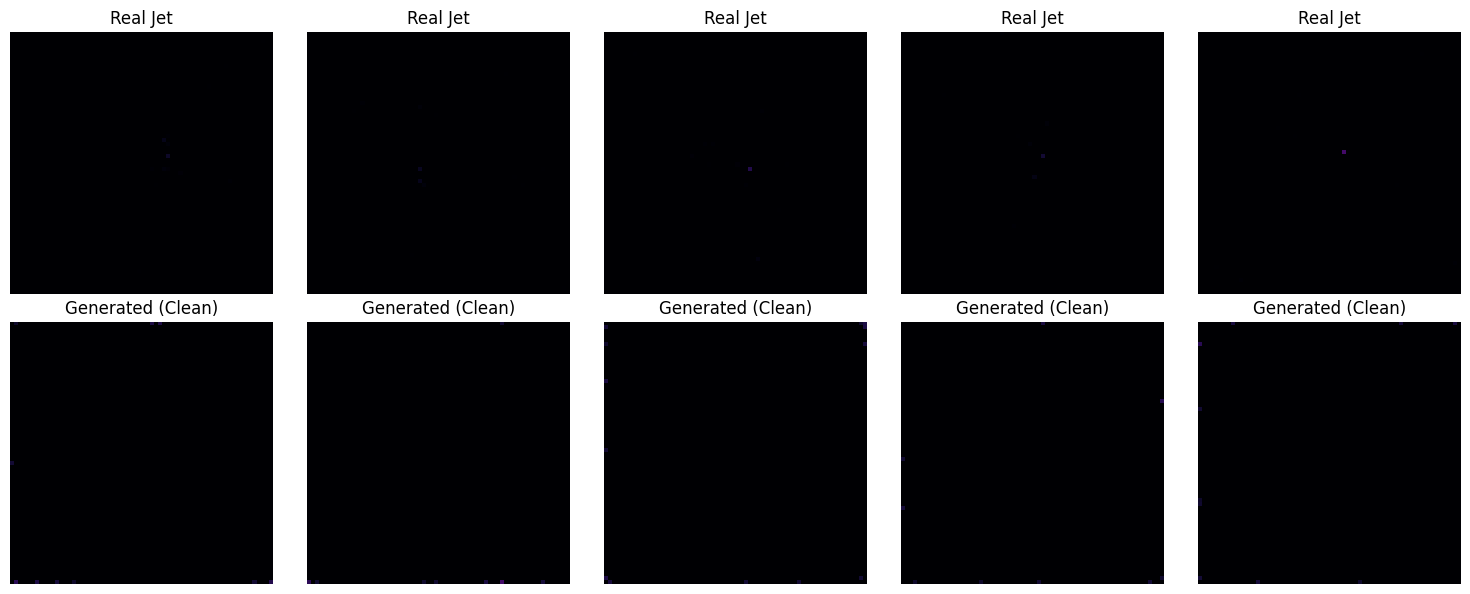

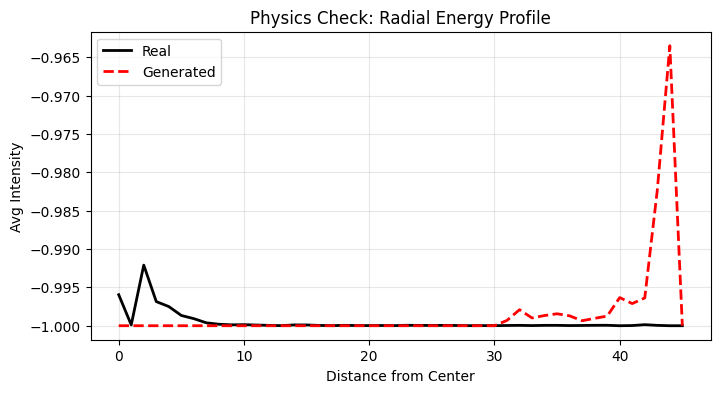

In [69]:
@torch.no_grad()
def evaluate_model(model, decoder, n_samples=10, threshold=-0.85):
    model.eval()
    decoder.eval()
    
    print(f"Generating {n_samples} samples...")
    
    # Start from Gaussian Noise
    x = torch.randn(n_samples, 1, 64, 64, device=device)
    
    # Solve ODE (Flow from Noise -> Data)
    steps = 50
    dt = 1.0 / steps
    for i in range(steps):
        t_val = i / steps
        t_vec = torch.full((n_samples,), t_val, device=device)
        v = model(x, t_vec)
        x = x + v * dt
        
    # Maps Expectation Values (~0 to -1) -> Pixels (-1 to 1)
    images_raw = decoder(x)
    
    # Background is -1.0. Model might predict -0.95 (noise).
    # We force anything below threshold to be exactly -1.0
    images_clean = torch.where(images_raw < threshold, torch.tensor(-1.0, device=device), images_raw)
    
    return images_clean.cpu().numpy()

fake_imgs = evaluate_model(model, decoder, n_samples=10, threshold=-0.85)
real_imgs = data_X[:10]
print(fake_imgs.max())
print(real_imgs.max())

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
vmin, vmax = -1.0, 1.0 

for i in range(5):
    axs[0, i].imshow(real_imgs[i].squeeze(), cmap='inferno', vmin=vmin, vmax=vmax)
    axs[0, i].set_title("Real Jet")
    axs[0, i].axis('off')
    
    axs[1, i].imshow(fake_imgs[i].squeeze(), cmap='inferno', vmin=vmin, vmax=vmax)
    axs[1, i].set_title("Generated (Clean)")
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

def radial_profile(imgs):
    N, H, W = imgs.shape
    Y, X = np.ogrid[:H, :W]
    center = (H//2, W//2)
    dist = np.sqrt((X - center[1])**2 + (Y - center[0])**2).astype(int)
    
    tbin = np.bincount(dist.ravel(), imgs.reshape(N, -1).mean(0))
    nr = np.bincount(dist.ravel())
    return tbin / np.maximum(nr, 1)

rad_real = radial_profile(real_imgs.squeeze())
rad_fake = radial_profile(fake_imgs.squeeze())

plt.figure(figsize=(8, 4))
plt.plot(rad_real, label='Real', color='black', linewidth=2)
plt.plot(rad_fake, label='Generated', color='red', linestyle='--', linewidth=2)
plt.xlabel("Distance from Center")
plt.ylabel("Avg Intensity")
plt.title("Physics Check: Radial Energy Profile")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()